# Coursera Applied Data Science Capstone Project
# The Battle of Neighborhoods
## By Zhemin Wu
### This is the main notebook for the Applied Data Science Capstone project

## Table of Contents

### 1.  [Introduction/Business Problem](#item1)

### 2.  [Data](#item2)

### 3.  [Methodology](#item3)

### 4.  [Results](#item4)

### 5.  [Discussion](#item5)

### 6.  [Conclusion](#item6)



#### Import necessary modules

In [129]:
# Import necessary modules
import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Part 1: Introduction/Business Problem <a class="anchor" id="item1"></a>

## The best neighbourhoods to settle down for a relocation
### Problem Description:
Assume we are a relocation service provider. One of our clients is going to relocate to another city due to some personal or business reasons, e.g relocating from Hong Kong to Shanghai. One of the most common questions he/she may ask is "Which neighborhood of that city is most comparable to my current home location and has best access to Gym/Restaurant/Theatre or less crowded/low housing cost?" Our task is just to help our client with pickcing up top neighbourhoods in the target city for our client according to the similarity to client's current home location and client's venue access preferences.   
<img src="skyline.jpg">
### Methodology:
To complete this task, we will need to do the following:
 - Collect geospatial coordinates of client's current home and all the neighborhoods in the city they are moving to.
 - Explore the popular venues around client's current home and all the neighborhoods around the target city using Foursquare's places API
 - Specify client's venue type preferences and cluster the neighborhoods according to their prefered venue types using a Machine Learning model (e.g. K-Means).
 - Using the venues info of client's home to get similar neighborhoods in the target city, and recommond the best one/ones according to client's preferences. We can achieve this last step by doing the following
     - We can combine the venues info of client's home with those in the target city and cluster togehter with K-Means, then we can get the cluster label of client's home 
     - Get a list of all the neighborhoods in the target city with the same cluster label
     - Pick the top neighborhoods according to client's preference

 

## Part 2: Data <a class="anchor" id="item2"></a>


### Collect geospatial coordinates data of client's current home location. The client currently lives near Central, Hong Kong 

In [30]:
client_address = "Central, Hong Kong"

geolocator = Nominatim(user_agent="hk_explorer")
location = geolocator.geocode(client_address)
client_latitude = location.latitude
client_longitude = location.longitude
print('The geographical coordinates of client\'s home at Central, Hong Kong are {}, {}.'.format(client_latitude, client_longitude))

The geographical coordinates of client's home at Central, Hong Kong are 22.2793278, 114.1628131.


### Collect base data of the target city. The client is moving to Shanghai in China
The wikipedia page of [administrative divisions of Shanghai](https://en.wikipedia.org/wiki/List_of_administrative_divisions_of_Shanghai) contains a table listing all the 15 districts in Shanghai with the area, population and population density info. We will grab the raw table from there using the Pandas web scraping func. We will also grab a dataframe of housing cost (C¥/㎡) for each district in Shanghai from [this page](https://m.creprice.cn/city/sh.html)

In [106]:
# Use Pandas web Scraping func to get dataframs from html tables.
# We will get a list of the administrative divisions of Shanghai
url = "https://en.wikipedia.org/wiki/List_of_administrative_divisions_of_Shanghai"
df_list = pd.read_html(url)

# The required table is the 4th one in the fetched table list
df_raw = df_list[3]
df_raw

Unnamed: 0_level_0                    County Level                        \
   Unnamed: 0_level_1                            Name Chinese  Hanyu Pinyin   
0                 NaN  Huangpu District[4](City seat)     黄浦区    Huángpǔ Qū   
1                 NaN                  Xuhui District     徐汇区      Xúhuì Qū   
2                 NaN              Changning District     长宁区  Chángníng Qū   
3                 NaN                Jing'an District     静安区    Jìng'ān Qū   
4                 NaN                  Putuo District     普陀区      Pǔtuó Qū   
5                 NaN                Hongkou District     虹口区    Hóngkǒu Qū   
6                 NaN                 Yangpu District     杨浦区     Yángpǔ Qū   
7                 NaN                 Pudong New Area    浦东新区  Pǔdōng Xīnqū   
8                 NaN                Minhang District     闵行区    Mǐnháng Qū   
9                 NaN                Baoshan District     宝山区    Bǎoshān Qū   
10                NaN                Jiading District     嘉定区    Jiādìng Qū   
11                NaN                Jinshan District     金山区    Jīnshān Qū   
12                NaN              Songjiang District     松江区  Sōngjiāng Qū   
13                NaN                 Qingpu District     青浦区     Qīngpǔ Qū   
14                NaN               Fengxian District     奉贤区   Fèngxián Qū   
15                NaN              Chongming District     崇明区  Chóngmíng Qū   

                                                      \
   Division code[2] Division code[2].1 Area (km²)[3]   
0            310101                HGP         20.46   
1            310104                XHI         54.76   
2            310105                CNQ         38.30   
3            310106                JAQ         36.88   
4            310107                PTQ         54.83   
5            310109                HKQ         23.48   
6            310110                YPU         60.73   
7            310115                PDX       1210.41   
8            310112                MHQ        370.75   
9            310113                BAO        270.99   
10           310114                JDG        464.20   
11           310116                JSH        586.05   
12           310117                SOJ        605.64   
13           310118                QPU        670.14   
14           310120                FXI        687.39   
15           310151                CMG       1185.49   

                                               
   Population (2018 census)[3] Density (/km²)  
0                       653800          31955  
1                      1084400          19803  
2                       694000          18120  
3                      1062800          28818  
4                      1281900          23380  
5                       797000          33944  
6                      1312700          21615  
7                      5550200           4585  
8                      2543500           6860  
9                      2042300           7536  
10                     1588900           3423  
11                      805000           1374  
12                     1762200           2910  
13                     1219100           1819  
14                     1152000           1676  
15                      688100            580

In [107]:
# Get housing prices for each district in Shanghai
housing_url = "https://m.creprice.cn/city/sh.html"
df_housing_list = pd.read_html(housing_url)

# The required dataframe is the first one, but in Chinese. We will combine this to the main dataframe later
df_housing = df_housing_list[0]

In [108]:
df_housing

,排名,行政区,平均单价（元/㎡）,环比
0,1,宝山区,46155,+2.52%
1,2,崇明区,23517,+7.42%
2,3,奉贤区,25331,+0.62%
3,4,虹口区,72213,+7.74%
4,5,黄浦区,108298,+7.70%
5,6,嘉定区,38504,+2.70%
6,7,静安区,79793,+3.59%
7,8,金山区,18071,-4.33%
8,9,闵行区,55592,+4.24%
9,10,浦东新区,65675,+4.50%


In [109]:
# Some clean up of the raw tables

# The column names are tuples, let's drop the 1st element of the tuple
df_raw.columns = df_raw.columns.map(lambda x:x[1])

# Let's drop columns we don't need
df_raw.drop(labels = ['Unnamed: 0_level_1', 'Hanyu Pinyin', 'Division code[2]', 'Division code[2].1'], axis=1, inplace=True)

# Rename columns
df_raw.columns = ['District', 'Chinese', 'Area', 'Total Population', 'Population Density']

# Clean up the Distric names, we only need the name
df_raw['District'] = df_raw.apply(lambda x:x['District'].split()[0], axis=1)

# Change housing dataframe column names
df_housing.columns = ['Rank', 'Chinese', 'Housing Cost', 'Growth Rate']

# Merging housing cost with the main dataframe
df_raw = df_raw.join(df_housing[['Chinese', 'Housing Cost']].set_index('Chinese'), on='Chinese')

# Drop the Chinese name column
df_raw.drop(labels=['Chinese'], axis=1, inplace=True)

df_raw

,District,Area,Total Population,Population Density,Housing Cost
0,Huangpu,20.46,653800,31955,108298
1,Xuhui,54.76,1084400,19803,83942
2,Changning,38.30,694000,18120,77511
3,Jing'an,36.88,1062800,28818,79793
4,Putuo,54.83,1281900,23380,66007
5,Hongkou,23.48,797000,33944,72213
6,Yangpu,60.73,1312700,21615,68258
7,Pudong,1210.41,5550200,4585,65675
8,Minhang,370.75,2543500,6860,55592
9,Baoshan,270.99,2042300,7536,46155


### Collect geospatial coordinates of all districts in Shanghai

In [110]:
geolocator = Nominatim(user_agent="Shanghai_explorer")

def getGeoinfo(address):
    loc = geolocator.geocode(address)
    return [loc.latitude, loc.longitude]

coordinates = df_raw.apply(lambda x:getGeoinfo(x['District']), axis=1)

df_raw['Latitude'] = np.stack(coordinates)[:,0]
df_raw['Longitude'] = np.stack(coordinates)[:,1]

df_raw

,District,Area,Total Population,Population Density,Housing Cost,Latitude,Longitude
0,Huangpu,20.46,653800,31955,108298,31.233593,121.479864
1,Xuhui,54.76,1084400,19803,83942,31.163698,121.427994
2,Changning,38.30,694000,18120,77511,31.209276,121.389986
3,Jing'an,36.88,1062800,28818,79793,31.229776,121.443060
4,Putuo,54.83,1281900,23380,66007,31.251326,121.391229
5,Hongkou,23.48,797000,33944,72213,31.266703,121.501751
6,Yangpu,60.73,1312700,21615,68258,31.262011,121.521430
7,Pudong,1210.41,5550200,4585,65675,31.221783,121.538740
8,Minhang,370.75,2543500,6860,55592,31.114767,121.376943
9,Baoshan,270.99,2042300,7536,46155,31.406634,121.485158


### Now take a look at these neighborhoods in Shanghai on a map

In [510]:
# create map of Shanghai using latitude and longitude values
loc = geolocator.geocode("Shanghai, China")
shanghai_lat = loc.latitude 
shanghai_lng = loc.longitude

map_shanghai = folium.Map(location=[shanghai_lat, shanghai_lng], zoom_start=10)

# add markers to map
for lat, lng, district in zip(df_raw['Latitude'], df_raw['Longitude'], df_raw['District'] ):
    label = district
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_shanghai)  
    
map_shanghai

### Now exploring nearby venues around all districts in Shanghai and around the client's current home location Central, Hong Kong

In [70]:
# Define Foursquare Credentials and Version (will remove credentials after running notebook for privacy protection)
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20210201' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [71]:
# We first create a simplified dataframe with only location names and coordinates and combine it with the client's home location so that we can explore venues together
# Note that client's home location will be appended as the last row of the simplified dataframe
df_simple = df_raw[['District', 'Latitude', 'Longitude']]
df_simple = df_simple.append({'District': 'Central, Hong Kong',
                              'Latitude': client_latitude,
                              'Longitude': client_longitude                    
                             }, ignore_index=True)

# Define a func for exploring nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Exploring around: %s" % name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Get all venues
all_venues = getNearbyVenues(df_simple['District'], df_simple['Latitude'], df_simple['Longitude'])

Exploring around: Huangpu
Exploring around: Xuhui
Exploring around: Changning
Exploring around: Jing'an
Exploring around: Putuo
Exploring around: Hongkou
Exploring around: Yangpu
Exploring around: Pudong
Exploring around: Minhang
Exploring around: Baoshan
Exploring around: Jiading
Exploring around: Jinshan
Exploring around: Songjiang
Exploring around: Qingpu
Exploring around: Fengxian
Exploring around: Chongming
Exploring around: Central, Hong Kong


In [72]:
all_venues.head()

,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Huangpu,31.233593,121.479864,Campanile Hotel and Restaurant,31.232123,121.479144,Hotel
1,Huangpu,31.233593,121.479864,Waldorf Astoria Shanghai on the Bund (外滩华尔道夫酒店),31.235479,121.485378,Hotel
2,Huangpu,31.233593,121.479864,Goodfellas,31.234878,121.486730,Italian Restaurant
3,Huangpu,31.233593,121.479864,The Bund (外滩),31.239316,121.486065,Waterfront
4,Huangpu,31.233593,121.479864,Mercato,31.236220,121.486530,Italian Restaurant


In [74]:
print("There are %d different categories" % len(all_venues['Venue Category'].unique()))

There are 159 different categories


In [115]:
all_venues

,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Huangpu,31.233593,121.479864,Campanile Hotel and Restaurant,31.232123,121.479144,Hotel
1,Huangpu,31.233593,121.479864,Waldorf Astoria Shanghai on the Bund (外滩华尔道夫酒店),31.235479,121.485378,Hotel
2,Huangpu,31.233593,121.479864,Goodfellas,31.234878,121.486730,Italian Restaurant
3,Huangpu,31.233593,121.479864,The Bund (外滩),31.239316,121.486065,Waterfront
4,Huangpu,31.233593,121.479864,Mercato,31.236220,121.486530,Italian Restaurant
...,...,...,...,...,...,...,...
1016,"Central, Hong Kong",22.279328,114.162813,PiCi,22.283248,114.152088,Italian Restaurant
1017,"Central, Hong Kong",22.279328,114.162813,Pololi,22.282837,114.153309,Hawaiian Restaurant
1018,"Central, Hong Kong",22.279328,114.162813,The Diplomat,22.282525,114.155017,Cocktail Bar
1019,"Central, Hong Kong",22.279328,114.162813,Chachawan,22.285581,114.148066,Thai Restaurant


## Part 3: Methodology  <a class="anchor" id="item3"></a>
Now it's the time to analize data we prepared to perform our task. 

## Basic neighborhood info
Let's first take a look at the basic info about the the 16 districts in Shanghai from our base dataframe.

#### Area
As we can see from the below chart, Pudong and Chongming are the two largest districts in Shanghai while Hongkou and Huangpu are the two smallest districts

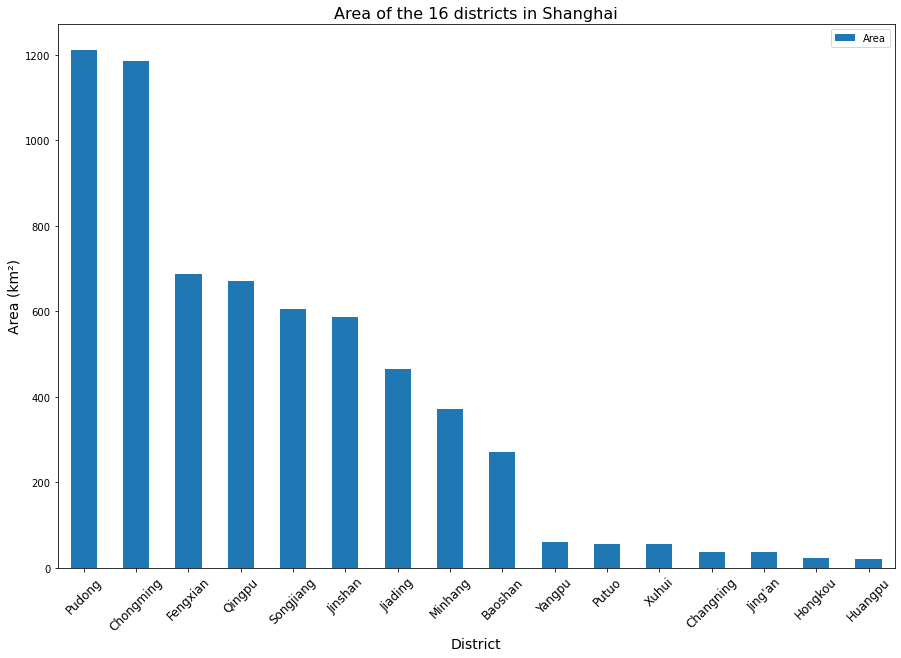

In [196]:
df_raw[['District', 'Area']].sort_values(by='Area', ascending=False).plot(kind='bar', x='District', y='Area', figsize=(15, 10))
plt.title("Area of the 16 districts in Shanghai", fontsize=16)
plt.xlabel("District", fontsize=14)
plt.ylabel("Area (km²)", fontsize=14)
ax = plt.gcf().gca()
ax.tick_params(axis='x', which='major', labelsize=12, rotation=45)

#### Population Density and Housing Costs
As we can expect, due to the small sizes, Hongkou and Huangpu are the two most crowded districts in Shanghai while Huangpu is also the most expensive neighbohood for housing. Jinshan and Chongming are the two relative remote areas with lowest population densities and housing costs. One interesting thing to note that, while Pudong is the largest district in Shanghai which also has a very low population density, it is actually not very cheap for housing. The main reason is that Pudong is a newer district developed in Shanghai with some new industrial centers settled down in the region. Pudong is also Shanghai's international logistics hub where the main international airport is located. 

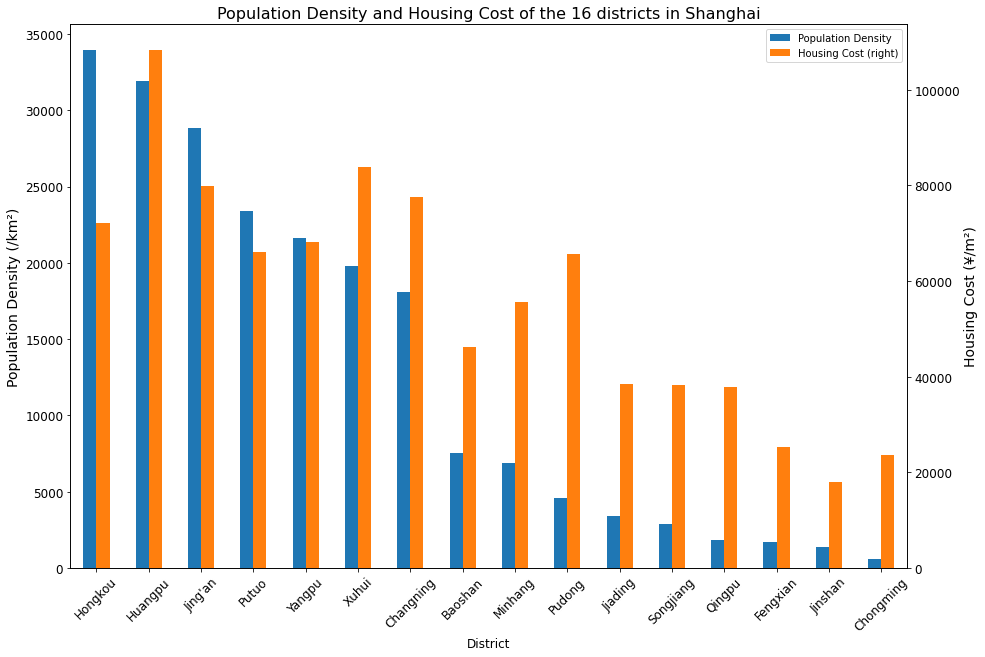

In [197]:
df_raw[['District', 'Population Density', 'Housing Cost']].sort_values(by='Population Density', ascending=False).plot(kind='bar', 
                                                                                                                      x='District',  
                                                                                                                      secondary_y= 'Housing Cost', 
                                                                                                                      figsize=(15, 10))
plt.title("Population Density and Housing Cost of the 16 districts in Shanghai", fontsize=16)
ax1, ax2 = plt.gcf().get_axes()
ax1.set_xlabel("District", fontsize=12)
ax1.set_ylabel("Population Density (/km²)", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='x', rotation=45)
ax2.set_ylabel("Housing Cost (¥/m²)", fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

### Exploratory data analysis on nearby venues around Shanghai and around Central, Hong Kong
Now, let's do some exploratory data analysis on the venues info data.

In [168]:
# one hot encoding
venues_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
venues_onehot['District'] = all_venues['District'] 

# move district column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,District,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Huangpu,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Huangpu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [581]:
# Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category
venues_grouped = venues_onehot.groupby('District').mean().reset_index()
venues_grouped.head()

,District,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Baoshan,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
1,"Central, Hong Kong",0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.0,...,0.0,0.0,0.0,0.01,0.01,0.00,0.02,0.00,0.0,0.01
2,Changning,0.0,0.0,0.01,0.00,0.00,0.01,0.00,0.00,0.0,...,0.0,0.0,0.0,0.03,0.00,0.01,0.00,0.01,0.0,0.00
3,Chongming,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
4,Fengxian,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00


#### Let's now select some main districts in Shanghai to explore the most common nearby venue types


In [214]:
# Let's define a func to plot top venue types for a given district
def plotTopVenues(district, num_top):
    df_for_district = venues_grouped[venues_grouped['District'] == district].T.reset_index()
    df_for_district.columns = ['Venue Type', 'Venue Type Frequency']
    df_for_district = df_for_district.iloc[1:]
    df_for_district= df_for_district.sort_values(by='Venue Type Frequency', ascending=False)
    df_for_district.iloc[0:num_top].plot(kind='bar', x='Venue Type', y='Venue Type Frequency', figsize=(15, 10))
    plt.gcf().gca().tick_params(axis='x', which='major', labelsize=12, rotation=45)
    plt.gcf().gca().set_title("The top %d most common venue types in %s" % (num_top, district), fontsize=16)
    plt.gcf().gca().set_xlabel('Venue Type', fontsize=14)
    plt.gcf().gca().set_ylabel('Venue Type Frequency', fontsize=14)

##### 1. Huangpu, the most crowded and expensive and busiest district in Shanghai
As we can see, as the most crowded and busiet district in Shanghai, the most common venue type in Huangpu is hotel, occupying over 25% of the venues nearby. There are also a lot of restaurants, shopping malls, parks and theaters. 

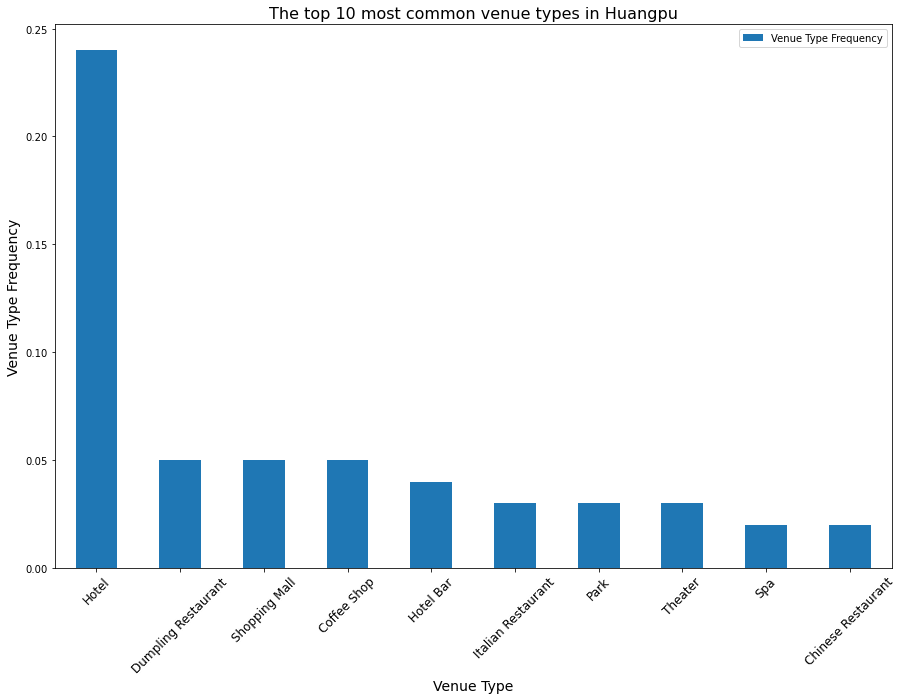

In [215]:
plotTopVenues('Huangpu', 10)

##### 2. Chongming, the only remote island in Shanghai
As we can see, we only got two types of venues in this area, farm and Chinese restaurant. This is as expected given it's remote location and it might not be a good choice for any new comers to this city.

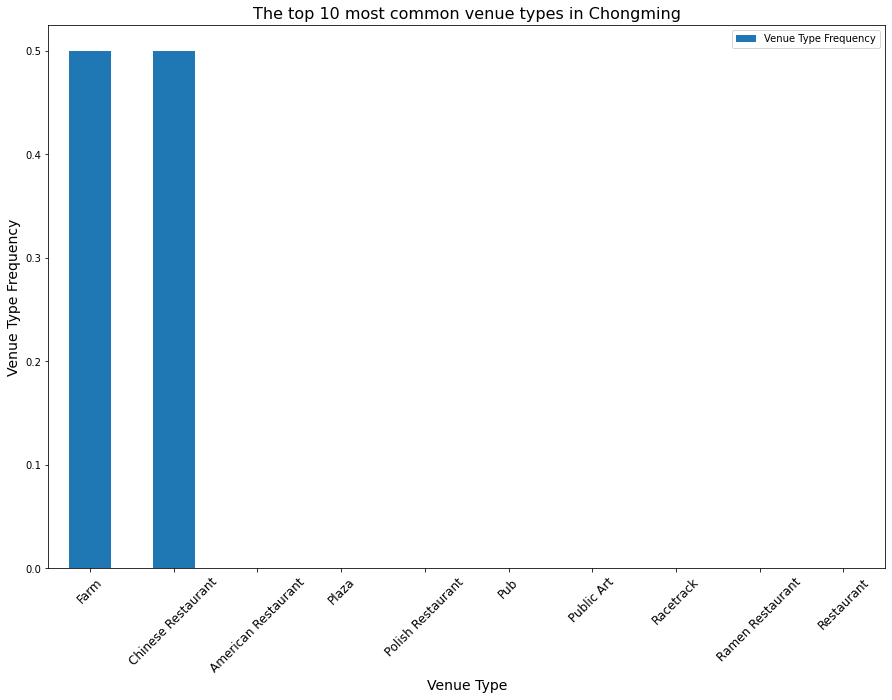

In [219]:
plotTopVenues('Chongming', 10)

##### 3. Pudong, the new industrial and financial hub in Shanghai
As we have seen earlier, Pudong is a newly developed district in Shanghai, which is not very crowded. We can see there are also a lot of hotels and restaurants around. We can also notice that "scenic lookout" is among the top 5 most common venue types in Pudong, which gives a reason why Pudong is now the most pupular destination for the tourists to Shanghai.


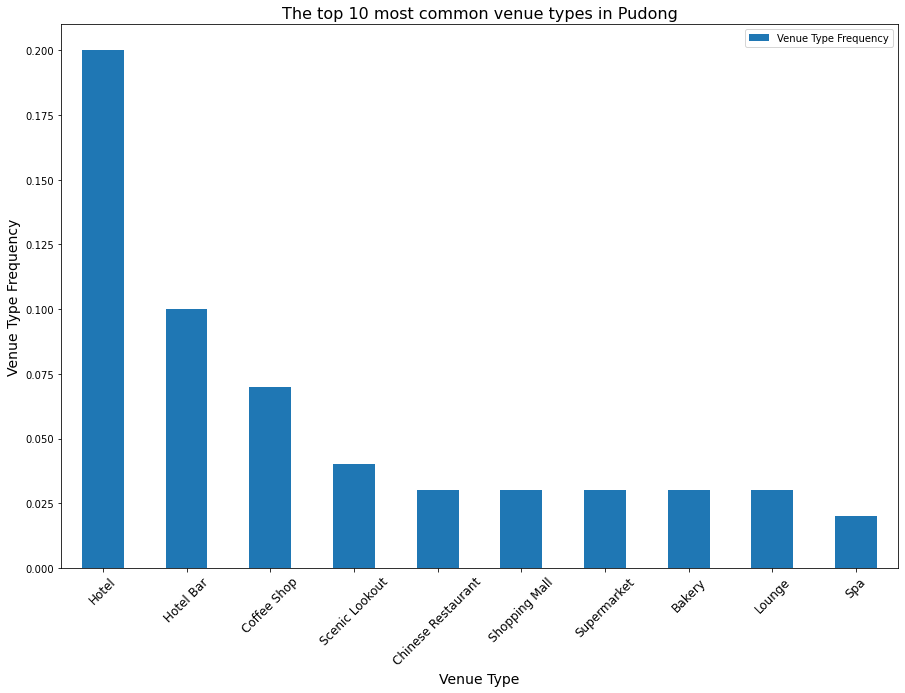

In [575]:
plotTopVenues('Pudong', 10)

##### 4. Finally, let's take a look at the client's home locataion, Central, Hong Kong
Hong Kong is an internaitonal financial hub. The Central, Hong Kong is the busiest area of the city. No doubt, it will have a lot of hotels, restaurants and bars. Notice that the "Scenic Lookout" is also among the top 10 common types in the Central, Hong Kong, which is similar to the Pudong district in Shanghai. 

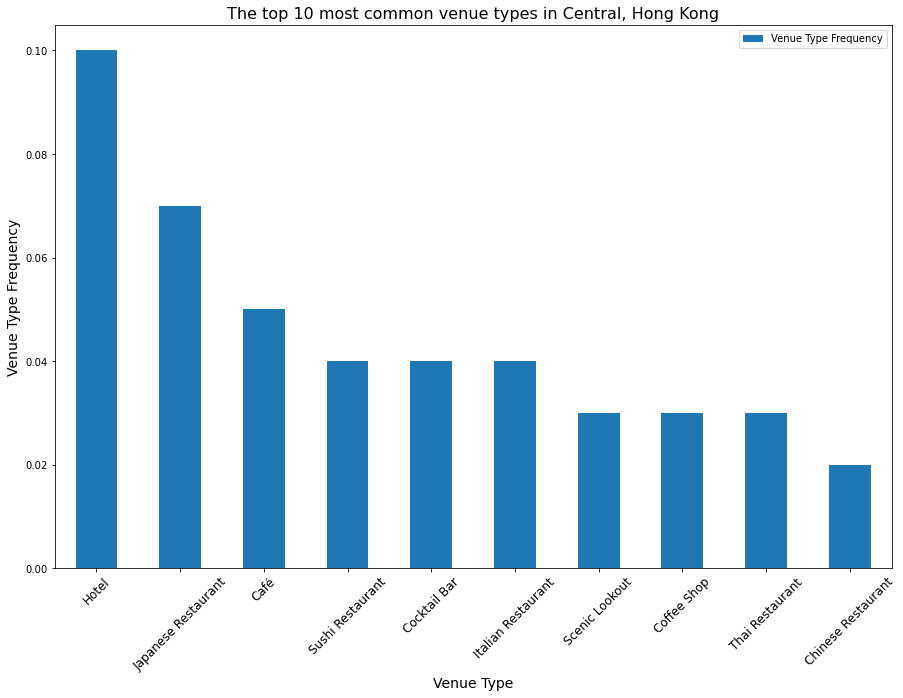

In [223]:
plotTopVenues('Central, Hong Kong', 10)

### Client Preference Scenarios

Now it's the time to analyze our venues data for our sttlement location recommendation task. Different clients may have different preferences of the access to the nearby venues and other considerations when choosing a place to live. Next, let's assume two different client preference scenarios and we will then analyze our data according to these scenarios and build up a model suitable to the scenario.

#### Scenario 1: The client doesn't have particular prefered venue type. The only considerations are similarity to his/her current location and if it's not very crowded.

So, for this scenario, the client only wants to choose a neighborhood which will be similar to their current home, but they don't want to move to a very crowded area. So, what we can do is to cluster the venues data of Shanghai together with the venues info of the Central, Hong Kong (which we have already combined together with our venues datafram). We can build a K-Means model to do so. And after that pick up a similar neighborhood with the lowest population density.

#### Scenario 2: The client only cares about the common daily life style venues and wants a place where they can afford buying an apartment

So, for this scenario, the client only cares about those most common daily life style venue types, including restaurants, bars, supermarkets, fitness facilities and theaters. On the other hand, the housing cost is another consideration. Thus, for this preference scenario, we can just include the relevant venue types when doing the clustering and then rank by the housing costs.

## Part 4: Results <a class="anchor" id="item4"></a>
In this section, we will adopt our methodologies for the different scenarios described earlier and build our machine learning models to cluster the districts in Shanghai


### Scenario 1

As mentioned earlier, in this scenario, the client cares about the overall similarity to his/her current home and also prefer the lower crowdedmess. Thus we cluster the entire venues data with a K-Means model.

In [486]:
# Let's define a function for clustering with given features list, which can be re-usable for later sections
def clusterWithFeatures(feature_list=[], kcluster=4):
    
    # Let's create the features matrix needed.
    features_df = venues_grouped.copy()
    df_clustering = features_df.drop('District', 1)
    
    if( len(feature_list)>0 ):
        df_clustering = df_clustering[feature_list]

    # run k-means clustering
    kmeans = KMeans(init='k-means++', n_clusters=kclusters, n_init=12, random_state=0).fit(df_clustering)

    # insert the cluster labels into the dataframe
    features_df.insert(1, 'Cluster Label', kmeans.labels_)
    features_df.set_index('District', inplace=True)

    # Get client's home cluster label
    print("The client's home \"Central, Hong Kong\" has a cluster label: %d" % features_df.loc['Central, Hong Kong']['Cluster Label'])

    # Let's now join the cluster info of Shanghai with the base datafram and return it
    return df_raw.join(features_df, on='District')

In [487]:
this_df = clusterWithFeatures(kcluster=4)

The client's home "Central, Hong Kong" has a cluster label: 1


In [582]:
# Let's first define a func to show cluster map, which can be reusable
# Use Mapbox customized tiles below, will remove the token before publishing in Github for privacy protection
token = ""
tile_str = "https://api.mapbox.com/styles/v1/wuzhemin/ckkt6is811srv17n47vmwye32/tiles/256/{z}/{x}/{y}@2x?access_token=" + token
def getMapWithClustering(cluster_df, weighting_feature='Area'):
    map_clusters = folium.Map(location=[shanghai_lat, shanghai_lng], zoom_start=10, 
                              tiles=tile_str, 
                              attr='Mapbox.com',
                              
                             )

    # set color scheme for the clusters
    num_cluster = len(cluster_df['Cluster Label'].unique())
    x = np.arange(num_cluster)
    ys = [i + x + (i*x)**2 for i in range(num_cluster)]
    colors_array = cm.rainbow_r(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, district, cluster, weight in zip(cluster_df['Latitude'], 
                                                   cluster_df['Longitude'], 
                                                   cluster_df['District'], 
                                                   cluster_df['Cluster Label'], 
                                                   cluster_df[weighting_feature]):
        label = folium.Popup(str(district) + ': Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius= weight/cluster_df[weighting_feature].sum()*100,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=1.0).add_to(map_clusters)
        
        #folium.TileLayer('openstreetmap').add_to(map_clusters)
      
    return map_clusters

In [583]:
this_map = getMapWithClustering(this_df, 'Population Density')
this_map

#### Scenario 1 results <a class="anchor" id="result1"></a>

Now let's take a look at the clustering on a map. 

As we can see from the clustering map above, we clustered the districts all around Shanghai with 4 clusters. Those districts with the red color are most similar to the client's home location in Hong Kong (cluster label 1) in terms of all nearby venue types, which are all colser to Shanghai's city center compared to other clusters. The radius of the markers represent the population density of that district. Larger marker means highly occupied region with high population density while smaller marker represents a region which is not crowded. We will disuss these results in the [Discussion Section](#item5)

### Scenario 2: 

So, for this scenario, given the client only cares about the certain daily life style venues. We will first filter our venues data with certain key words. We will then build a K-Means model to fit the filtered venue types only. On the other hand, the housing cost is another consideration. We will then look into that info also from our clustering results on the map.

In [574]:
# Get all venue types
all_venues_types = all_venues['Venue Category'].unique()

# Define a list of daily life style venue types keywords and a func to check this
def is_daily_life_venue(venue):
    venue_keywords = ["Restaurant", "Bar", "Supermarket", "Theater", "Fitness", "Sports" ]
    rv = False
    for keyword in venue_keywords:
        if keyword in venue:
            rv = True
            break
    return rv                    

# Filter out the restaurant types only
daily_life_features = list(all_venues_types[list(map(lambda x:is_daily_life_venue(x), all_venues_types))])

# Do clustering with restaurant features only
daily_life_df = clusterWithFeatures(daily_life_features)

The client's home "Central, Hong Kong" has a cluster label: 0


In [572]:
this_map = getMapWithClustering(daily_life_df, weighting_feature='Housing Cost')
this_map

#### Scenario 2 results <a class="anchor" id="result2"></a>

Now let's take a look at the clustering on the above map.

The cluster label for client's home location Central, Hong Kong is 0 this time. As we can see from the clustering map below, those districts with the purple color are most similar to the client's home location in terms of all nearby restaurants, bars, supermarkets, fitness facilities and theaters. We got 3 districts in this cluster, Qingpu, Putuo and Changning. The radius of the markers represent the housing cost of that district. Larger marker means it's more expensive to buy a house/apartment in the region. We will discuss these results in the [Discussion Section](#item5)

## Part 5: Discussion <a class="anchor" id="item5"></a>

So, up to this point, we have built up our machine learning models to cluster the 16 districts in Shanghai according to two different client preference scnenarios. Let's now take a look at these results and make our recommendations to our client.

### Scenario 1

As mentioned earlier, in this scenario, the client cares about the overall similarity to his/her current home and also prefer the lower crowdedmess. As we have seen from the [clustering results](#result1), those districts with the red color are most similar to the client's home location in Hong Kong (cluster label 1) in terms of all nearby venue types, which are all colser to Shanghai's city center compared to other clusters. Among the Cluster 1, Pudong stands out as an exceptional case which is smilar enough to our client's home but with a very low pupulation density. So it's a very good fit to our client's preference. Thus we will recommend **Pudong** to our client in this Scenario.

### Scenario 2

In this scenario, the client only cares about those most common daily life style venue types, including restaurants, bars, supermarkets, fitness facilities and theaters. The client also puts more weighting on the housing cost. As we can see from the [clustering results](#result2), those districts with the purple color are most similar to the client's home location in terms of all nearby restaurants, bars, supermarkets, fitness facilities and theaters. We got 3 districts in this cluster, Qingpu, Putuo and Changning. As we can see, among the 3 purple districts, Qingpu has the lowest housing cost. This could the the best choice for the client. However, if the client cares about the distance to the city center, it's relatively a bit too far away. For the remaining two similar choices in this cluster, Putuo and Changning have comparable housing costs while Putuo has slightly lower margin. Thus we will recommend **Qingpu** if the cliend doesn't have any preference on the distance to the city center, otherwise we will recommend **Putuo**.  

## Part 6: Conclusion <a class="anchor" id="item6"></a>

In this Capstone project, we performed a recommendation task for choosing the best settlment neighborhood for our client who's relocating from Central, Hong Kong to Shanghai. 

We first obtained some basic data from the web about the 16 districts in Shanghai, including the area, the population, population density and housing cost. We then retrieve the geospatial corrdinates of the 16 districts and combined those with the geospatial corrdinates of the Central, Hong Kong, the client's home location, in a single dataframe. We then use the Foursquare Places API to explore the common popular nearby venues around these locations. And finally, we grouped the venue types based on the locations and calculated the corresponding appearance frequencies of each venue type for each location, which then becomes the base data set for building our machine learning models for clustering.

Next, we assumed two different client preferences of the access to the nearby venues and other considerations and performed our recommendation tasks accordingly:
- **Scenario 1**: The client doesn't have particular prefered venue type. The only considerations are similarity to his/her current location and if it's not very crowded.

So, for this scenario, the client only wants to choose a neighborhood which will be similar to their current home in terms of all types of nearby venues, but they don't want to move to a very crowded area. So, we built up a K-Means model to cluster all the venues data of Shanghai together with the venues info of the Central, Hong Kong. From the clustering results, we observed that the districts sharing the same cluster label of the Central, Hong Kong are all very close to Shanghai city center. Among those, Pudong has the lowest pupulation density. Thus we recommend **Pudong** to our client in this scenario

- **Scenario 2**: The client only cares about the common daily life style venues and wants a place where they can afford buying an apartment

So, for this scenario, given the client only cares about the certain daily life style venues. We first filtered our venues data for those daily life venues. We then built a K-Means model to fit the filtered venue types only. From the clustering results, we observed 3 districts which are similar to the client's home in terms of these daily life venues. Among the 3 districts, **Qingpu** has the lowest housing cost, which is then our top recommendation to the client in this scenario. However, it's a bit far away to the Shanghai city center. If our client has concerns about the distance to the city center, then we recommend **Putuo**, which is closer to the city center but is still a cheap place for housing if compared with all other districts around. 
